In [3]:
import random
import math
import time

import numpy as np
import matplotlib.pyplot as plt

from typing import Dict, Tuple, List

# Inhomogeneous Poisson process: vehicle arrival process<a name="1"></a>


First we implement two methods of simulating this inhomogeneous Poisson processes for $1000$ runs: 
1. the revised method
2. the thinning approach

In [4]:
MIN_PER_DAY = 60*24
MIN_PER_HOUR = 60

In [5]:
class VehicleArrivalProcess: 
    def __init__(self,
                 decay_rate_dict: Dict={
                    (0, 6*60): 0.2,
                    (6*60, 8*60): 0.9, 
                    (8*60, 12*60): 0.5, 
                    (12*60, 15*60): 0.6,  
                    (15*60, 17*60): 1.0, 
                    (17*60, 19*60): 0.6, 
                    (19*60, 24*60): 0.5, 
                }):
        """Simulating a inhomogeneous Poisson process for vehicle arrival:
        Args:
        ------
        decay_rate_dict: Dict[Tuple: float]
            the rates over time-intervals (/min) over the period of 24 hours.
        """
        self.decay_rate_dict = decay_rate_dict 
        self.time_intervals = list(decay_rate_dict.keys())
        self.decay_rates = list(decay_rate_dict.values())
        self.upper_bound = max(self.decay_rates) # U_\lambda
    
    def decay_rate(self, t): 
        """decay rate over given time-interval. 
        Args: 
        -----
        t: float 
            current timestep (minutes past observing startpoint 00:00) 
        Returns: 
        -----
        decay rate at timestep `t`
        """
        t = t%(MIN_PER_DAY) # map t to a 24-hours period 
        for i, ti in enumerate(self.time_intervals): 
            low, high = ti
            if low <= int(t) < high: # NOTE the conversion between timestep and minute index!
                return self.decay_rates[i]
        
    def revised_method(self, 
                       num_simulations: int=1000, 
                       T: int=MIN_PER_DAY):
        """Simulating with revised method.
        Args: 
        -----
        T: int
            the observing period (/min) of each simulation. 
        """
        simulation_matrix = list()
        st = time.time()
        for _ in range(num_simulations):
            events = list()
            x = 0
            
            # simulating the number of events by sampling from a 2d homogeneous Poisson process
            m = np.random.poisson(self.upper_bound*T) 
            
            for i in range(1, m+1):
                # sampling points chronologically from homogeneous Poisson processes
                u = random.random()
                x = x + (T-x)*(1 - u**(1/(m-i+1))) # sample the arrival time based on inverse distribution method 
                y = np.random.random()* self.upper_bound 
                
                # obtain inhomogeneous Poisson processes sample with rejection method.
                if y <= self.decay_rate(x):
                    events.append(x)
                    
            simulation_matrix.append(events)
        
        et = time.time()
        print(f'[Revised method] Simulation time: {et-st: .2f}s')
        return simulation_matrix 
    
    def thinning_approach(self,
                          num_simulations: int=1000, 
                          T: int=MIN_PER_DAY):
        """Simulating with thinning approach.
        Args: 
        -----
        num_simulations: int
            the number of simulation runs 
        T: int
            the observing period (/min) of each simulation. 
            
        Returns:
        ------
        simulation_matrix: List[List(num_arrivals)](num_simulations)
            arrival timestep (minutes past 00:00) of cars for each simulation run. 
        """
        simulation_matrix = list()
        st = time.time()
        for _ in range(num_simulations):
            t = 0
            events = list()
            
            while True:
                t = t + np.random.exponential(self.upper_bound) # smaple the inter-event time
                if t > T:
                    break
                    
                # sapmle y-coordinate 
                u = random.random()*self.upper_bound
                
                # obtain inhomogeneous Poisson processes sample with rejection method.
                if u <= self.decay_rate(t): # probabilities of arriving
                    events.append(t)
                    
            simulation_matrix.append(events)
            
        et = time.time()
        print(f'[Thinning approach] Simulation time: {et-st: .2f}s')
        return simulation_matrix

In [6]:
vap = VehicleArrivalProcess()
rev_simulation = vap.revised_method()
thi_simulation = vap.thinning_approach()

[Revised method] Simulation time:  2.11s
[Thinning approach] Simulation time:  2.37s


## (i) plot the average number of cars that arrived and left per minute over the period of 24 hours

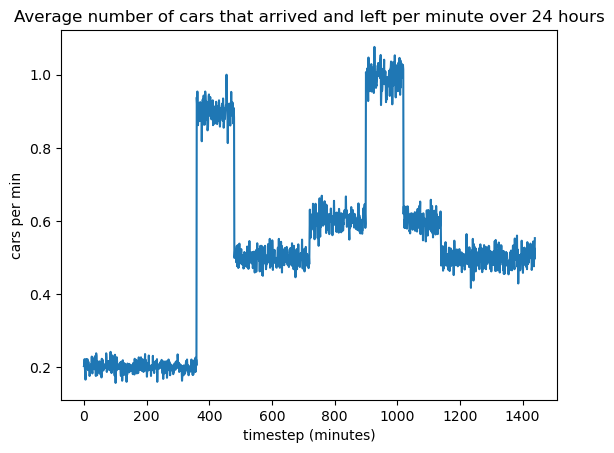

In [8]:
def num_pass_per_min(simulation_matrix):
    num_simulations = len(simulation_matrix)
    
    num = [0]*(MIN_PER_DAY) # num of car that arrived and left at ith minute
    for sm in simulation_matrix: 
        for s in sm: # s: timesteps past 00:00
            num[int(s)] += 1 # 
    num = [elem/num_simulations for elem in num]
    return num
    
num_per_min = num_pass_per_min(rev_simulation)
timeline = [*range(MIN_PER_DAY)]
plt.title('Average number of cars that arrived and left per minute over 24 hours')
plt.xlabel('timestep (minutes)')
plt.ylabel('cars per min')

plt.plot(timeline, num_per_min, '-')

## (ii) Also plot the cumulative number of cars that arrived per minute over the period of 24 hours


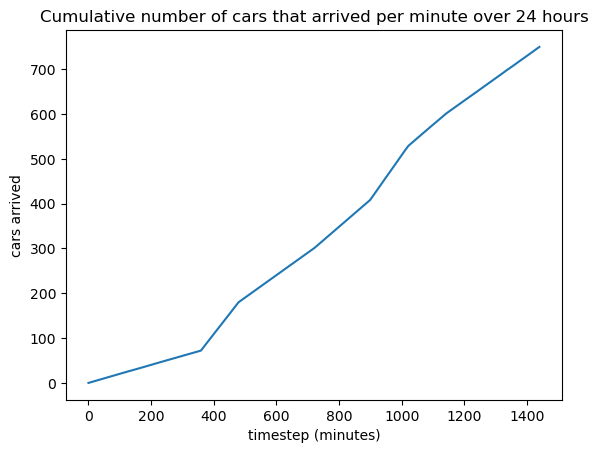

In [9]:
def cumulative_num_per_min(simulation_matrix):
    cumulative_num = num_pass_per_min(rev_simulation)
    for i in range(1, len(cumulative_num)):
        cumulative_num[i] += cumulative_num[i-1]
    return cumulative_num

cumulative_num = cumulative_num_per_min(rev_simulation)
timeline = [*range(MIN_PER_DAY)]
plt.title('Cumulative number of cars that arrived per minute over 24 hours')
plt.xlabel('timestep (minutes)')
plt.ylabel('cars arrived')

plt.plot(timeline, cumulative_num, '-')

## (iii) print the average number of cars that arrived in one day 

In [12]:
def average_daily_num_car(simulation_matrix):
    num = [len(sm) for sm in simulation_matrix]
    mean = sum(num) / len(num)
    return mean

rev_num_daily_car = average_daily_num_car(rev_simulation)
thi_num_daily_car = average_daily_num_car(thi_simulation)

print(f'[Revised method] {int(rev_num_daily_car)} cars per day')
print(f'[Thinning approach] {int(thi_num_daily_car)} cars per day')

[Revised method] 749 cars per day
[Thinning approach] 749 cars per day


## (iv) print the average time when the first car arrived

In [14]:
def average_first_car(simulation_matrix):
    first = [sm[0] for sm in simulation_matrix]
    mean = sum(first) / len(first)
    return mean

rev_first_car = average_first_car(rev_simulation)
thi_first_car = average_first_car(thi_simulation)

print(f'[Revised method]: {rev_first_car: .4f} minutes past the observation startpoint 00:00')
print(f'[Thinning approach]: {thi_first_car: .4f} minutes past the observation startpoint 00:00')

[Revised method]:  4.8477 minutes past the observation startpoint 00:00
[Thinning approach]:  4.8996 minutes past the observation startpoint 00:00


## Notes for myself
Simulation of inhomogeneous Poisson processes. 

### inhomogeneous Poisson process in any order

**principle**: using rejection to *thin* a homogenerous (unit) Poisson process to give a target inhomogeneous process.

**definition**: 
- targetd 2d region $\Omega$ bounded by $x \in [0, T]$ and $y \in [0, \lambda(x)]$
- envolope 2d region $\overline{\Omega}$ bounded by $x \in [0, T]$ and $y \in [0, U_\lambda]$, where $ 0\leq \lambda(t) \leq U_\lambda$ is some upper bound.

**receipt**:
- simulate a unit Poisson process on $\overline{\Omega}$
- apply rejection sampling on $\overline{\Omega}$

### chronological inhomogeneous Poisson process
#### revised algorithm
When $x$ are sampled chronologically,

$$
\begin{aligned}
F_{i}(x) &= P(x_i \leq x)\\
&= 1 - P(x_i > x)\\
&= 1 - P(x_i>x, \ldots, x_m > x)\\
&= 1 - P(x_i>x)\ldots P(x_m > x)\\
&= 1 - \left[1-F_{U_{i-1}}(x)\right]^{m-i+1}
\end{aligned}
$$
<span style='color:red'>where $U_{i-1} = U(x_{i-1}, T]$ </span>(different range for different events), thus that 

$$
\begin{aligned}
F_{U_{i-1}}(x) &= \color{red}{\frac{x-x_{i-1}}{T-x_{i-1}}}\\
\end{aligned}
$$

Substitute $F_{U_{i-1}}(x)$ into the equation of $F_{i}(x)$, we have 

$$
F_{i}(x) = 1 - \left[1-\frac{x-x_{i-1}}{T-x_{i-1}}\right]^{m-i+1}
$$

with inverse transformation method, we relate $u \sim U[0, 1]$ to $x_i \sim F_i$, where $x_i \in (x_{i-1}, T]$

$$
\begin{aligned}
u &= F_i^{-1}(x_i) \\
&= 1 - \left[1-\frac{x_i-x_{i-1}}{T-x_{i-1}}\right]^{m-i+1}\Leftrightarrow \\
x_i &= x_{x-1} + \left[1 - (1-u)^{\frac{1}{m-i+1}}\right]\left(T-x_{i-1}\right)\\
x_i &= x_{x-1} + \left[1 - u^{\frac{1}{m-i+1}}\right]\left(T-x_{i-1}\right)
\end{aligned}
$$
